In [78]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from darts import TimeSeries
import numpy as np
import matplotlib.dates as mdates
plt.style.use('ggplot')

Using seaborn seems to create dependency conflicts with darts, so all graphs will be pure matplotlib. 

# Data injestion

In [139]:
train_dir = Path(Path.cwd().parent, "data", "raw", "train.csv")
df = pd.read_csv(train_dir)

In [140]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [141]:
# How many rows, columns are there?
df.shape

(913000, 4)

In [148]:
# Need to convert that date object to datetime for easier manipulation
# will also breakdown the date into pieces for further analysis
df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['quarter'] = df['date'].dt.quarter
df['month_year']  = df['date'].dt.to_period('M')

In [149]:
# What does the data look like?
df.head()

,date,store,item,sales,day,month,year,quarter,month_year
0,2013-01-01,1,1,13,1,1,2013,1,2013-01
1,2013-01-02,1,1,11,2,1,2013,1,2013-01
2,2013-01-03,1,1,14,3,1,2013,1,2013-01
3,2013-01-04,1,1,13,4,1,2013,1,2013-01
4,2013-01-05,1,1,10,5,1,2013,1,2013-01


In [150]:
# What timerange do we have
df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [85]:
# How many unique items per store are there
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [86]:
df.head()

,date,store,item,sales,day,month,year,quarter,month_year
0,2013-01-01,1,1,13,1,1,2013,1,2013-01-01
1,2013-01-02,1,1,11,2,1,2013,1,2013-01-01
2,2013-01-03,1,1,14,3,1,2013,1,2013-01-01
3,2013-01-04,1,1,13,4,1,2013,1,2013-01-01
4,2013-01-05,1,1,10,5,1,2013,1,2013-01-01


# Time series plotting

## Sales by Quarter

In [151]:
total_sales_by_quarter = df.groupby(['store','quarter'], as_index = False).sum(numeric_only = True)[['store', 'quarter', 'sales']]
total_sales_by_quarter.head()

,store,quarter,sales
0,1,1,831060
1,1,2,1215812
2,1,3,1258696
3,1,4,1010035
4,2,1,1179980


/var/folders/v6/dbfxlq956gn5vzm_219g_zgw0000gn/T/ipykernel_13995/22824734.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", 1,"", 2, "", 3, "", 4]);


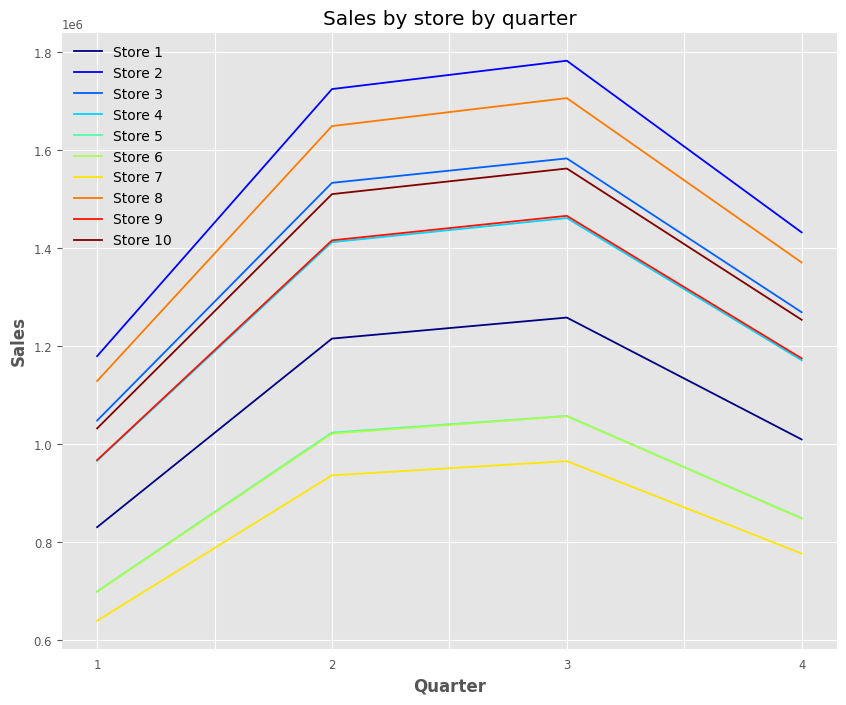

In [152]:
fig, ax = plt.subplots(figsize = (10,8))
jet = plt.cm.jet
colors = jet(np.linspace(0, 1, len(total_sales_by_quarter['store'].unique())))

for c, n in zip(colors,total_sales_by_quarter['store'].unique()):
    df_temp = total_sales_by_quarter[total_sales_by_quarter['store'] == n]
    ax.plot(df_temp['quarter'], df_temp['sales'], label = f"Store {n}", c = c)
ax.legend()
ax.set_xlabel('Quarter')
ax.set_ylabel('Sales')
ax.set_title('Sales by store by quarter')
# Forcing tick labels because "1.5/2.5 quarters arent useful"
ax.set_xticklabels(["", 1,"", 2, "", 3, "", 4]); 


## Monthly

In [153]:
total_sales_by_month = df.groupby(['store','month'], as_index = False).sum(numeric_only = True)[['store', 'month', 'sales']]
total_sales_by_month['month_name'] = df['Month'] = pd.to_datetime(total_sales_by_month['month'], format='%m').dt.month_name().str[:3]
total_sales_by_month.head()

,store,month,sales,month_name
0,1,1,249352,Jan
1,1,2,250494,Feb
2,1,3,331214,Mar
3,1,4,374268,Apr
4,1,5,414653,May


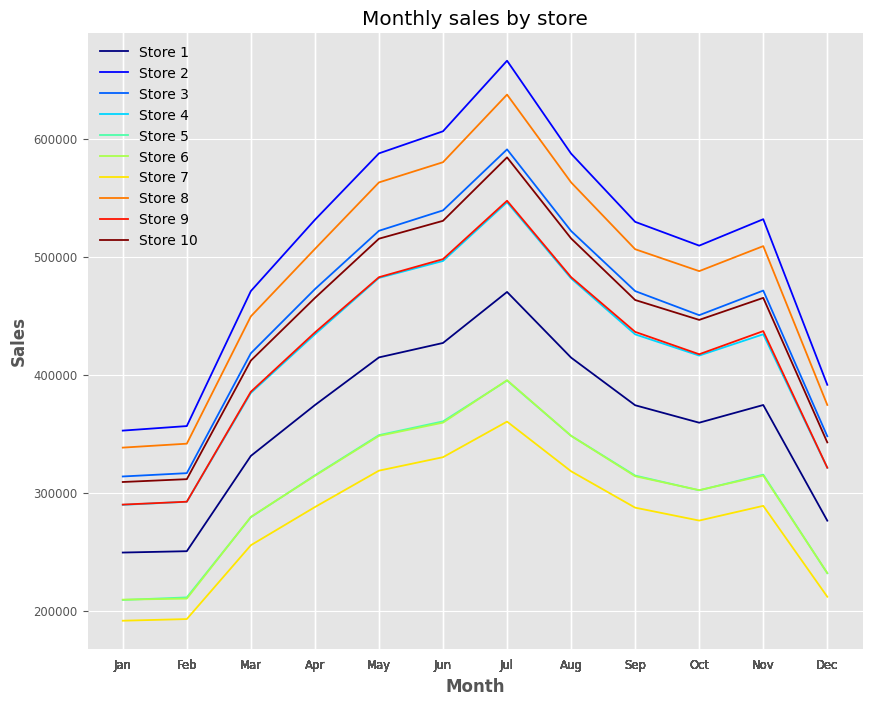

In [132]:
fig, ax = plt.subplots(figsize = (10,8))
for c, n in zip(colors,total_sales_by_month['store'].unique()):
    df_temp = total_sales_by_month[total_sales_by_month['store'] == n]
    ax.plot(df_temp['month'], df_temp['sales'], label = f"Store {n}", c = c)
ax.legend()
ax.set_xlabel('Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly sales by store')
ax.set_xticks(total_sales_by_month['month']);
ax.set_xticklabels(total_sales_by_month['month_name']);

Thee definitely appears to be some seasonality in the data, as would be expected. We can look at the entire date range to try and identify any cyclical or trend information as well. 

## Yearly

In [154]:
total_sales_by_year = df.groupby(['store','year'], as_index = False).sum(numeric_only = True)[['store', 'year', 'sales']]
total_sales_by_year['year'] = total_sales_by_year['year'].astype('str')
total_sales_by_year['year'] = pd.to_datetime(total_sales_by_year['year'])
total_sales_by_year.head()

,store,year,sales
0,1,2013-01-01,717840
1,1,2014-01-01,826786
2,1,2015-01-01,861710
3,1,2016-01-01,937493
4,1,2017-01-01,971774


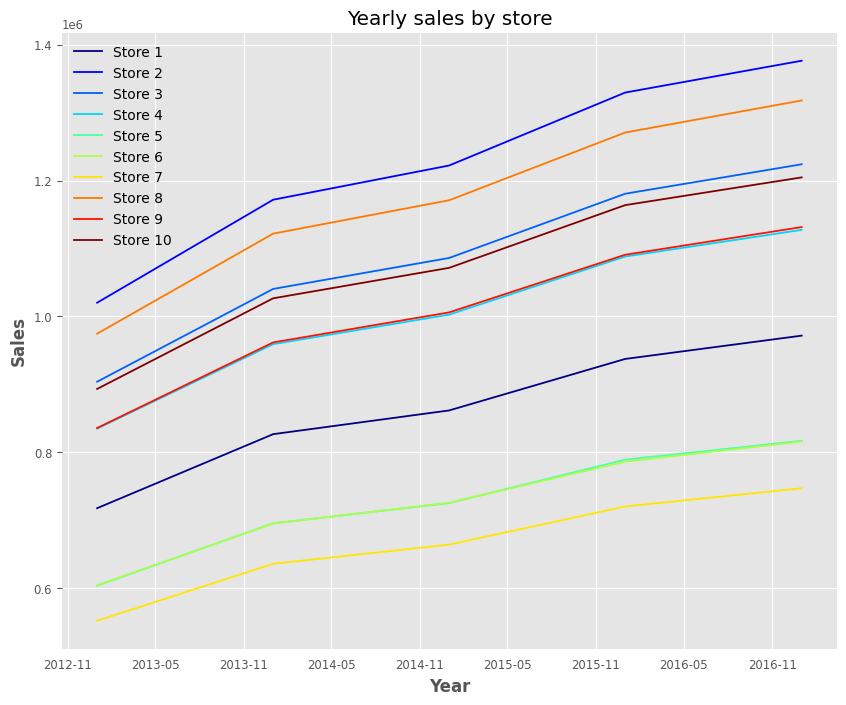

In [155]:
fig, ax = plt.subplots(figsize = (10,8))
for c, n in zip(colors,total_sales_by_year['store'].unique()):
    df_temp = total_sales_by_year[total_sales_by_year['store'] == n]
    ax.plot(df_temp['year'], df_temp['sales'], label = f"Store {n}", c = c)
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Sales')
ax.set_title('Yearly sales by store')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

In [156]:
month_year_group = df.groupby(['store','month_year'], as_index = False).sum(numeric_only = True)[['store', 'month_year', 'sales']]
month_year_group['month_year'] =month_year_group['month_year'].astype('str')
month_year_group['month_year'] = pd.to_datetime(month_year_group['month_year'])
month_year_group.head()

,store,month_year,sales
0,1,2013-01-01,41077
1,1,2013-02-01,41306
2,1,2013-03-01,55827
3,1,2013-04-01,61523
4,1,2013-05-01,69272


In [157]:
month_year_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   store       600 non-null    int64         
 1   month_year  600 non-null    datetime64[ns]
 2   sales       600 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 14.2 KB


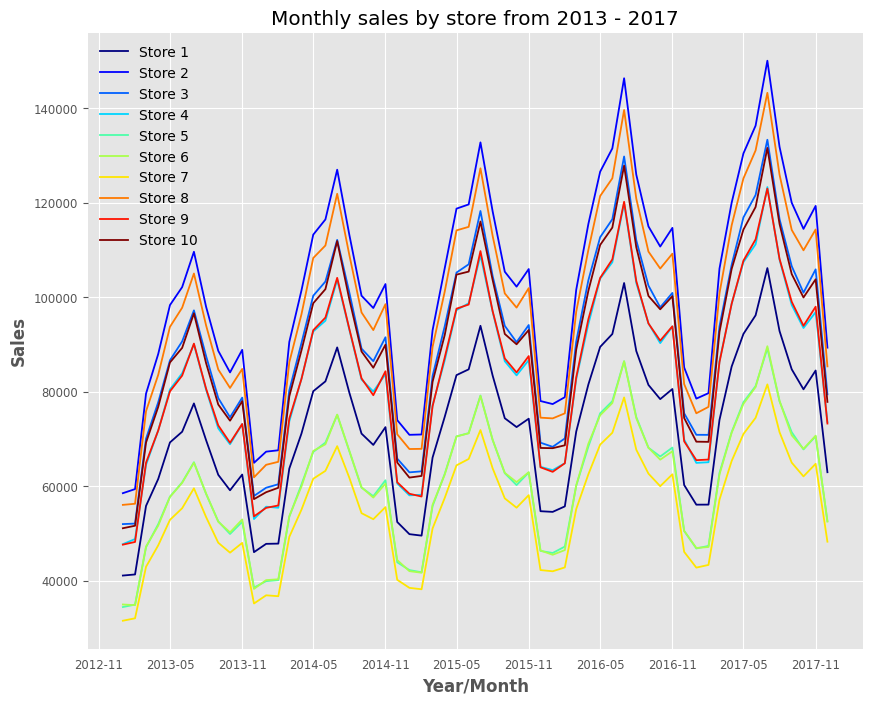

In [158]:
fig, ax = plt.subplots(figsize = (10,8))
for c, n in zip(colors,month_year_group['store'].unique()):
    df_temp = month_year_group[month_year_group['store'] == n]
    ax.plot(df_temp['month_year'], df_temp['sales'], label = f"Store {n}", c = c)
ax.legend()
ax.set_xlabel('Year/Month')
ax.set_ylabel('Sales')
ax.set_title('Monthly sales by store from 2013 - 2017')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))

Here we see the yearly seasonality as before, together with a general upwards trend.
There don't appear to be any cyclical trends in the data. 

# Store plots

In [159]:
df.head()

,date,store,item,sales,day,month,year,quarter,month_year,Month
0,2013-01-01,1,1,13,1,1,2013,1,2013-01,Jan
1,2013-01-02,1,1,11,2,1,2013,1,2013-01,Feb
2,2013-01-03,1,1,14,3,1,2013,1,2013-01,Mar
3,2013-01-04,1,1,13,4,1,2013,1,2013-01,Apr
4,2013-01-05,1,1,10,5,1,2013,1,2013-01,May


In [160]:
store_sales_df = df.groupby('store', as_index= False).sum(numeric_only = True)[['store', 'sales']]

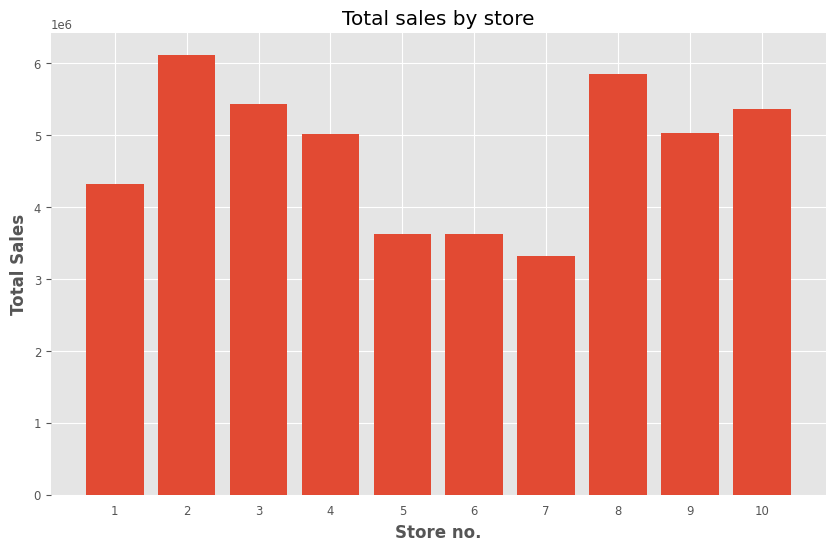

In [161]:
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x = store_sales_df['store'], height = store_sales_df['sales'])
ax.set_xlabel('Store no.')
ax.set_ylabel('Total Sales')
ax.set_title('Total sales by store')
ax.set_xticks(list(range(1,11)));

# Saving df

In [167]:
df = df.rename(columns = {"Month":"month_name"})
save_dir = Path(Path.cwd().parent, "data", "interim", "exploration_df.pkl")
df.to_pickle(save_dir)